# Jump2Digital Prueba Data Science


### Objetivos de la prueba:
- Seleccionar dos conjuntos de datos y unificarlos teniendo en cuenta que nuestro conjunto base es el de los alquileres.
- Realizar el preprocesamiento de datos necesario para garantizar que los datos sean precisos.
- Aplicar un análisis de componentes principales para reducir las dimensiones conjunto de datos.

## Tabla de contenidos:
1. [Preprocesado del primer datastet](#Primer-dataset:-precio-de-viviendas-en-Barcelona)
2. [Preprocesado del segundo dataset](#Segundo-dataset:-exposición-al-ruido-de-la-población-en-Barcelona)
3. [Unión de los datasets](#Unión-de-los-dos-datasets)
4. [Extra: Análisis exploratorio de datos](#Extra:-Análisis-exploratorio-de-datos)
5. [Extra: Predicción de precios en funcíon de superficie](#Extra:-predicción-de-precios-de-viviendas-en-función-de-solo-1-atributo:-su-superficie)
6. [Reducción de dimensionalidad mediante PCA](#Reducción-de-dimensionalidad-mediante-PCA)

### Importar librerias y cargar datasets

In [363]:
# Importar librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import prince

In [364]:
df_alquiler = pd.read_csv("training_data/2017_lloguer_preu_trim.csv")
df_ruido = pd.read_csv("training_data/2017_poblacio_exposada_barris_mapa_estrategic_soroll_bcn_long.csv")

Antes de empezar a procesar los conjuntos de datos es importante tener una idea general sobre el significado de nuestros atributos y los datos con los que vamos a tratar. 

### Primer dataset: precio de viviendas en Barcelona

In [365]:
df_alquiler.info()
df_alquiler.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Any             584 non-null    int64  
 1   Trimestre       584 non-null    int64  
 2   Codi_Districte  584 non-null    int64  
 3   Nom_Districte   584 non-null    object 
 4   Codi_Barri      584 non-null    int64  
 5   Nom_Barri       584 non-null    object 
 6   Lloguer_mitja   584 non-null    object 
 7   Preu            546 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 36.6+ KB


,Any,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,2017,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99
1,2017,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà mensual (Euros/mes),905.26
2,2017,1,1,Ciutat Vella,3,la Barceloneta,Lloguer mitjà mensual (Euros/mes),722.78
3,2017,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Lloguer mitjà mensual (Euros/mes),895.28
4,2017,1,2,Eixample,5,el Fort Pienc,Lloguer mitjà mensual (Euros/mes),871.08


Tenemos pues un dataset compuesto por 584 elementos en el que cada elemento cuenta con 8 columnas. A simple vista estas columnas son: el año (2017) y el trimestre en el que se recolectó la información,el nombre y código del distrito donde está la vivienda, el nombre y código del barrio donde está la vivienda, el precio y una columna llamada alquiler medio ("Lloguer_mitja") que exploraremos a continuación. 

Antes de ello nos deshacemos de la columna año ("Any") que no nos aporta información puesto que es el mismo valor para todos los elementos del dataset.

In [366]:
df_alquiler["Any"].unique()

array([2017], dtype=int64)

In [367]:
df_alquiler.drop(columns = ["Any"], inplace = True)

Procedemos a la entender el signficado del atributo "Lloguer_mitja".

In [368]:
print("Valores diferentes:", df_alquiler["Lloguer_mitja"].nunique())
df_alquiler["Lloguer_mitja"].value_counts()


Valores diferentes: 2


Lloguer_mitja
Lloguer mitjà mensual (Euros/mes)              292
Lloguer mitjà per superfície (Euros/m2 mes)    292
Name: count, dtype: int64

Observamos que este atributo es categórico y presenta solo dos posibles valores de los cuales hay el mismo número de elementos: Alquiler medio mensual (Euros/mes) o alquiler medio por superficie (Euros/m2 mes). Si ahora nos fijamos en la columna "Preu" observamos que la columna "LLoguer_mitja" nos indica las unidades del valor precio. Continuamos explorando el atributo "Precio".

In [369]:
print("Valores diferentes:", df_alquiler["Preu"].nunique())
df_alquiler["Preu"].describe()

Valores diferentes: 504


count     546.000000
mean      421.009231
std       446.178147
min         4.450000
25%        12.645000
50%       161.565000
75%       770.347500
max      1882.420000
Name: Preu, dtype: float64

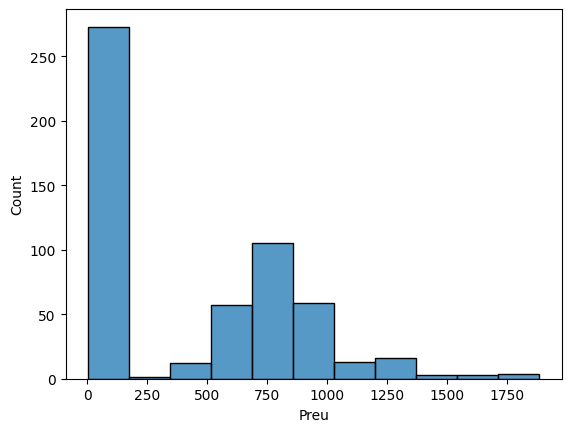

In [370]:
sns.histplot(data = df_alquiler["Preu"]);

Resalta la alta distribución estandar de los precios. Generando un histograma de los precios confirmamos que hay un problema y es que como ya hemos visto antes, en la columna precios están mezlados los precios absolutos y los precios en función del area de la vivienda. Para seguir indagando separamos el conjunto de datos en precio absoluto y precio por m2. 

In [371]:
df_alquiler[df_alquiler["Lloguer_mitja"] == "Lloguer mitjà mensual (Euros/mes)"].head()

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99
1,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà mensual (Euros/mes),905.26
2,1,1,Ciutat Vella,3,la Barceloneta,Lloguer mitjà mensual (Euros/mes),722.78
3,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Lloguer mitjà mensual (Euros/mes),895.28
4,1,2,Eixample,5,el Fort Pienc,Lloguer mitjà mensual (Euros/mes),871.08


In [372]:
df_alquiler[df_alquiler["Lloguer_mitja"] == "Lloguer mitjà per superfície (Euros/m2 mes)"].head()

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
292,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà per superfície (Euros/m2 mes),13.50
293,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà per superfície (Euros/m2 mes),14.14
294,1,1,Ciutat Vella,3,la Barceloneta,Lloguer mitjà per superfície (Euros/m2 mes),19.46
295,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Lloguer mitjà per superfície (Euros/m2 mes),15.01
296,1,2,Eixample,5,el Fort Pienc,Lloguer mitjà per superfície (Euros/m2 mes),12.77


In [373]:
df_alquiler_precio = df_alquiler[df_alquiler["Lloguer_mitja"] == "Lloguer mitjà mensual (Euros/mes)"]
df_alquiler_precio_m2 = df_alquiler[df_alquiler["Lloguer_mitja"] == "Lloguer mitjà per superfície (Euros/m2 mes)"]  

In [374]:
print("Valores nulos:", df_alquiler_precio[df_alquiler_precio["Preu"].isnull()].shape[0])
df_alquiler_precio[df_alquiler_precio["Preu"].isnull()].tail()

Valores nulos: 19


,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
230,4,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà mensual (Euros/mes),NaN
260,4,7,Horta-Guinardó,42,la Clota,Lloguer mitjà mensual (Euros/mes),NaN
265,4,8,Nou Barris,47,Can Peguera,Lloguer mitjà mensual (Euros/mes),NaN
274,4,8,Nou Barris,56,Vallbona,Lloguer mitjà mensual (Euros/mes),NaN
276,4,9,Sant Andreu,58,Baró de Viver,Lloguer mitjà mensual (Euros/mes),NaN


In [375]:
print("Valores nulos:", df_alquiler_precio_m2[df_alquiler_precio_m2["Preu"].isnull()].shape[0])
df_alquiler_precio_m2[df_alquiler_precio_m2["Preu"].isnull()].tail()

Valores nulos: 19


,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
522,4,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà per superfície (Euros/m2 mes),NaN
552,4,7,Horta-Guinardó,42,la Clota,Lloguer mitjà per superfície (Euros/m2 mes),NaN
557,4,8,Nou Barris,47,Can Peguera,Lloguer mitjà per superfície (Euros/m2 mes),NaN
566,4,8,Nou Barris,56,Vallbona,Lloguer mitjà per superfície (Euros/m2 mes),NaN
568,4,9,Sant Andreu,58,Baró de Viver,Lloguer mitjà per superfície (Euros/m2 mes),NaN


Observamos lo siguiente:
* El número de viviendas (292) de ambos conjuntos de datos es el mismo.
* Para cada vivienda los atributos son los mismos en ambos conjuntos de datos, respectivamente. Es decir, si por ejemplo la vivienda número 5 está en el barrio "el Fort Pienc" en el conjunto de datos de precio absoluto, también la vivienda número 5 pertenece al barrio "el Fort Pienc" en el conjunto de datos precio en m2.  	
*  Esto dos puntos anteriores también se cumplen con los valores NaN.

Lo que sucede es que en nuestro conjunto de datos principal las viviendas están repetidas cambiando únicamente la forma de expresar el precio. A continuación eliminamos las viviendas duplicadas y añadimos la columna "Àrea", que es más util que el precio por m2, el cuál siempre podremos volver a recuperar en un futuro diviendo la columna precio entre la columna área.

In [376]:
Area = (df_alquiler[df_alquiler["Lloguer_mitja"] == "Lloguer mitjà mensual (Euros/mes)"]["Preu"] / 
        df_alquiler[df_alquiler["Lloguer_mitja"] == "Lloguer mitjà per superfície (Euros/m2 mes)"]["Preu"].reset_index(drop = True)
       ).round(2)

In [377]:
df_alquiler_area = df_alquiler
largo = df_alquiler[df_alquiler["Lloguer_mitja"] == "Lloguer mitjà mensual (Euros/mes)"].shape[0]

In [378]:
df_alquiler_area = df_alquiler_area.loc[:largo - 1].drop(columns = "Lloguer_mitja")
df_alquiler_area["Àrea (m2)"] = Area
df_alquiler_area["Preu (euros/mes)"] = df_alquiler_area["Preu"]
df_alquiler_area.drop(columns = "Preu", inplace = True)

In [379]:
df_alquiler_area.info()
df_alquiler_area.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Trimestre         292 non-null    int64  
 1   Codi_Districte    292 non-null    int64  
 2   Nom_Districte     292 non-null    object 
 3   Codi_Barri        292 non-null    int64  
 4   Nom_Barri         292 non-null    object 
 5   Àrea (m2)         273 non-null    float64
 6   Preu (euros/mes)  273 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 16.1+ KB


,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Àrea (m2),Preu (euros/mes)
0,1,1,Ciutat Vella,1,el Raval,54.44,734.99
1,1,1,Ciutat Vella,2,el Barri Gòtic,64.02,905.26
2,1,1,Ciutat Vella,3,la Barceloneta,37.14,722.78
3,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",59.65,895.28
4,1,2,Eixample,5,el Fort Pienc,68.21,871.08


Ahora trataremos los valores NaN. Hay 19 valores NaN de un total de 292 valores, lo que representa un 6.5% del total de viviendas. A continuación estudiaremos si en algunos barrios predomina más que en otros la falta del registro del área y precio de las viviendas.

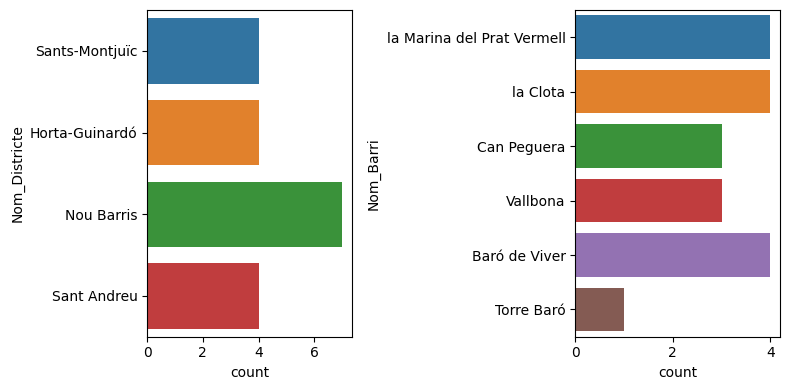

In [380]:
# Para visualizar cuántos valores nulos hay por distrito y por barrio
df_alquiler_area_nulos = df_alquiler_area[df_alquiler_area["Preu (euros/mes)"].isnull()]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.countplot(df_alquiler_area_nulos, y = "Nom_Districte", ax = axes[0])
sns.countplot(df_alquiler_area_nulos, y = "Nom_Barri", ax = axes[1])
plt.tight_layout()
plt.show()

In [381]:
# Para ver cuántos viviendas hay en total para esos distritos y barrios
print(df_alquiler_area["Nom_Districte"].value_counts())
np.unique(df_alquiler_area["Nom_Barri"].value_counts()) # Hay 4 apariciones por barrio

Nom_Districte
Nou Barris             52
Horta-Guinardó         44
Sant Martí             40
Sants-Montjuïc         32
Sant Andreu            28
Eixample               24
Sarrià-Sant Gervasi    24
Gràcia                 20
Ciutat Vella           16
Les Corts              12
Name: count, dtype: int64


array([4], dtype=int64)

Son 4 de los 10 distritos y solo 6 de los 73 barrios los que concentran esta falta de documentación en el área y precio de las viviendas. Como en nuestro dataset hay 4 apariciones de viviendas por barrio y para los barrios "la Marina del Prat Vermell", "la Clota", "Varó de Viver", "Can Peguera", "Vallbona" vemos que niguna o ninguna excepto una vivienda tiene el área o precio documentado eliminamos estos barrios. Para el barrio "Torre Baró" como solo hay 1 de 4 viviendas sin documentar vamos a intentar hallar un estimador de su precio y área a partir del del resto de viviendas de la zona. Como se trata de solo 1 valor que queremos estimar no vamos a usar métodos de machine learning para intentar predecirlo, sino que vamos a utilizar el área y precios medios del resto de viviendas de su mismo barrio y de su mismo distrito (para evitar sobreajustar con las viviendas de su barrio).

In [382]:
# Eliminar valores NaN menos Torre Baró
df_alquiler_area_nulos = df_alquiler_area_nulos[df_alquiler_area_nulos["Nom_Barri"] != "Torre Baró"]
df_alquiler_area.drop(df_alquiler_area_nulos.index, inplace = True)
df_alquiler_area.reset_index(drop = True, inplace = True)

In [383]:
df_alquiler_area[df_alquiler_area["Nom_Barri"] == "Torre Baró"].select_dtypes("float").describe()

,Àrea (m2),Preu (euros/mes)
count,3.000000,3.000000
mean,62.603333,443.156667
std,5.060646,22.974040
min,57.590000,418.070000
25%,60.050000,433.150000
50%,62.510000,448.230000
75%,65.110000,455.700000
max,67.710000,463.170000


In [384]:
df_alquiler_area[df_alquiler_area["Nom_Districte"] == "Nou Barris"].select_dtypes("float").describe()

,Àrea (m2),Preu (euros/mes)
count,45.000000,45.000000
mean,59.902667,583.030000
std,9.059335,101.000639
min,34.860000,302.520000
25%,54.310000,533.300000
50%,57.850000,600.840000
75%,64.110000,654.580000
max,85.670000,750.430000


In [385]:
# El único null que queda es Torre Baró
index_null = df_alquiler_area[df_alquiler_area["Preu (euros/mes)"].isnull()].index[0]

media_barrio = df_alquiler_area[df_alquiler_area["Nom_Barri"] == "Torre Baró"].select_dtypes("float").mean().values
media_distrito = df_alquiler_area[df_alquiler_area["Nom_Districte"] == "Nou Barris"].select_dtypes("float").mean().values
df_alquiler_area.at[index_null, "Àrea (m2)"] = (media_barrio[0] + media_distrito[0]) / 2
df_alquiler_area.at[index_null, "Preu (euros/mes)"] = (media_barrio[1] + media_distrito[1]) / 2
# Comprobación
df_alquiler_area.iloc[index_null]

Trimestre                    2
Codi_Districte               8
Nom_Districte       Nou Barris
Codi_Barri                  54
Nom_Barri           Torre Baró
Àrea (m2)               61.253
Preu (euros/mes)    513.093333
Name: 119, dtype: object

Finalmente tenemos un dataset de los alquileres donde ya no hay viviendas repetidas  y con información sobre la superficie de cada vivienda. 

In [386]:
df_alquiler_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Trimestre         274 non-null    int64  
 1   Codi_Districte    274 non-null    int64  
 2   Nom_Districte     274 non-null    object 
 3   Codi_Barri        274 non-null    int64  
 4   Nom_Barri         274 non-null    object 
 5   Àrea (m2)         274 non-null    float64
 6   Preu (euros/mes)  274 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 15.1+ KB


### Segundo dataset: exposición al ruido de la población en Barcelona

Nuestro segundo dataset contiene información sobre el porcentaje de población que está expuesta a los diferentes rangos de ruido, según la tipología de la fuente y la franja horaria. Al igual que en el anterior dataset de alquileres, los datos están disponibles a nivel de ciudad, distrito y barrio.

In [387]:
df_ruido.info()
df_ruido.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18980 entries, 0 to 18979
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Codi_Districte  18980 non-null  int64 
 1   Nom_Districte   18980 non-null  object
 2   Codi_Barri      18980 non-null  int64 
 3   Nom_Barri       18980 non-null  object
 4   Concepte        18980 non-null  object
 5   Rang_soroll     18980 non-null  object
 6   Valor           18980 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.0+ MB


,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,Valor
0,1,Ciutat Vella,1,el Raval,TOTAL_D,<40 dB,7.73%
1,1,Ciutat Vella,1,el Raval,TOTAL_D,40-45 dB,26.98%
2,1,Ciutat Vella,1,el Raval,TOTAL_D,45-50 dB,7.38%
3,1,Ciutat Vella,1,el Raval,TOTAL_D,50-55 dB,11.97%
4,1,Ciutat Vella,1,el Raval,TOTAL_D,55-60 dB,19.85%


Para entender la columna concepto consultamos la web del ayuntamiento de Barcelona sobre mapas de ruido ambientales que dice lo siguiente:
https://ajuntament.barcelona.cat/ecologiaurbana/es/mapas-datos-ambientales

El mapa de ruido muestra los niveles sonoros de diferentes tipos de fuentes sonoras y también el nivel de ruido global (la suma de todas las fuentes). El tipo de fuente sonora puede clasificarse en dos grupos:

Fuentes sonoras pedidas por normativa:
  * Ruido total (TOTAL)
  * Ruido de tráfico viario (TRANSIT)
    * Ruido de grandes infraestructuras viarias (GI_TR)
  * Ruido de tráfíco ferroviario y tranvia (FFCC)
  * Ruido industrial (INDUST)


Fuentes sonoras adicionales, que son de relevancia en la ciudad
  * Ruido en calles peatonales (VIANANTS)
  * Ruido de ocio y aglomeración de personas (OCI)
  * Ruido que proviene de la actividad en parques (PARCS) y en patios interiores (PATIS) 

Se excluyen fuentes de ruido puntuales, como obras, vecindad, etcétera.

Por otra parte los sufijos D (7h-21h), E (21h-23h) y N (23h-7h) definen el periodo horario en el que se ha medido el ruido, siendo EDN el dia entero.

In [388]:
df_ruido["Concepte"].unique()

array(['TOTAL_D', 'TOTAL_E', 'TOTAL_N', 'TOTAL_DEN', 'TRANSIT_D',
       'TRANSIT_E', 'TRANSIT_N', 'TRANSIT_DEN', 'GI_TR_D', 'GI_TR_E',
       'GI_TR_N', 'GI_TR_DEN', 'FFCC_D', 'FFCC_E', 'FFCC_N', 'FFCC_DEN',
       'INDUST_D', 'INDUST_E', 'INDUST_N', 'INDUST_DEN', 'VIANANTS_D',
       'VIANANTS_E', 'OCI_N', 'PATIS_D', 'PATIS_E', 'PARCS_D'],
      dtype=object)

Comprobamos que todos los barrios tengan el mismo número de apariciones, lo que nos dirá si el conjunto de datos está balanceado en este aspecto.

In [389]:
# Comprobar si todos los barrios tienen el mismo número de apariciones
len(np.unique(
    np.array(df_ruido["Nom_Barri"].value_counts()))) == 1

True

### Unión de los dos datasets

Nuestro objetivo es unir los dos datasets que hemos tratado en uno solo para poder relacionar de forma más sencilla los precios de alquiler y el nivel de ruido. Esto lo podemos hacer gracias a que ambos conjuntos de datos comparten los mismos barrios y distritos.

In [390]:
# Comprobar que los códigos y nombres siguen el mismo orden en ambos datasets
comparar = ["Codi_Districte", "Nom_Districte", "Codi_Barri", "Nom_Barri"]

for elemento in comparar:
    print(df_alquiler_area["Codi_Districte"].unique().tolist() == df_ruido["Codi_Districte"].unique().tolist())

True
True
True
True


In [391]:
df_unido = pd.merge(df_alquiler_area, df_ruido, how = "inner", on = comparar)

In [392]:
df_unido.info()
df_unido.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71240 entries, 0 to 71239
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Trimestre         71240 non-null  int64  
 1   Codi_Districte    71240 non-null  int64  
 2   Nom_Districte     71240 non-null  object 
 3   Codi_Barri        71240 non-null  int64  
 4   Nom_Barri         71240 non-null  object 
 5   Àrea (m2)         71240 non-null  float64
 6   Preu (euros/mes)  71240 non-null  float64
 7   Concepte          71240 non-null  object 
 8   Rang_soroll       71240 non-null  object 
 9   Valor             71240 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 5.4+ MB


,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Àrea (m2),Preu (euros/mes),Concepte,Rang_soroll,Valor
0,1,1,Ciutat Vella,1,el Raval,54.44,734.99,TOTAL_D,<40 dB,7.73%
1,1,1,Ciutat Vella,1,el Raval,54.44,734.99,TOTAL_D,40-45 dB,26.98%
2,1,1,Ciutat Vella,1,el Raval,54.44,734.99,TOTAL_D,45-50 dB,7.38%
3,1,1,Ciutat Vella,1,el Raval,54.44,734.99,TOTAL_D,50-55 dB,11.97%
4,1,1,Ciutat Vella,1,el Raval,54.44,734.99,TOTAL_D,55-60 dB,19.85%


Comprobamos que la unión que hemos hecho es correcta:

In [393]:
print(
    "La longitud del dataset unido es"
    , df_unido.shape[0] 
    , ", que es igual al nº de viviendas * nº posibles tipos de ruidos * nº posibles de rangos sonoros = "
    , df_alquiler_area.shape[0] * df_ruido["Concepte"].nunique() * df_ruido["Rang_soroll"].nunique()
)

La longitud del dataset unido es 71240 , que es igual al nº de viviendas * nº posibles tipos de ruidos * nº posibles de rangos sonoros =  71240


Del dataset unido comprobamos si hay filas duplicadas y cambiamos el tipo de dato de las columnas object a category para optiminar el almacenamiento de memoria. Además, eliminamos el % de la columna "Valor" y la convertimos en float para poder manipularla más facilmente.

In [394]:
df_unido.duplicated().value_counts()

False    71240
Name: count, dtype: int64

No hay filas duplicadas.

In [395]:
columnas_categorico = ["Trimestre", "Codi_Districte", "Nom_Districte", "Codi_Barri", "Nom_Barri", "Concepte", "Rang_soroll"]
df_unido[columnas_categorico] = df_unido[columnas_categorico].astype("category")
df_unido["Valor (%)"] = df_unido["Valor"].str.rstrip("%").astype("float")
df_unido.drop(columns = "Valor", inplace = True)

In [396]:
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71240 entries, 0 to 71239
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Trimestre         71240 non-null  category
 1   Codi_Districte    71240 non-null  category
 2   Nom_Districte     71240 non-null  category
 3   Codi_Barri        71240 non-null  category
 4   Nom_Barri         71240 non-null  category
 5   Àrea (m2)         71240 non-null  float64 
 6   Preu (euros/mes)  71240 non-null  float64 
 7   Concepte          71240 non-null  category
 8   Rang_soroll       71240 non-null  category
 9   Valor (%)         71240 non-null  float64 
dtypes: category(7), float64(3)
memory usage: 2.1 MB


Hemos conseguido que nuestro conjunto de datos ocupe algo menos de la mitad de memoria que antes de cambiar el datatype de las variables.

### Extra: Análisis exploratorio de datos

Tras el preprocesado de nuestros conjuntos de datos, donde los hemos limpiado, ordenado y unidos en un solo conjunto realizamos un análisis exploratorio de datos que nos ayude a ver las relaciones entre las variables del dataset.

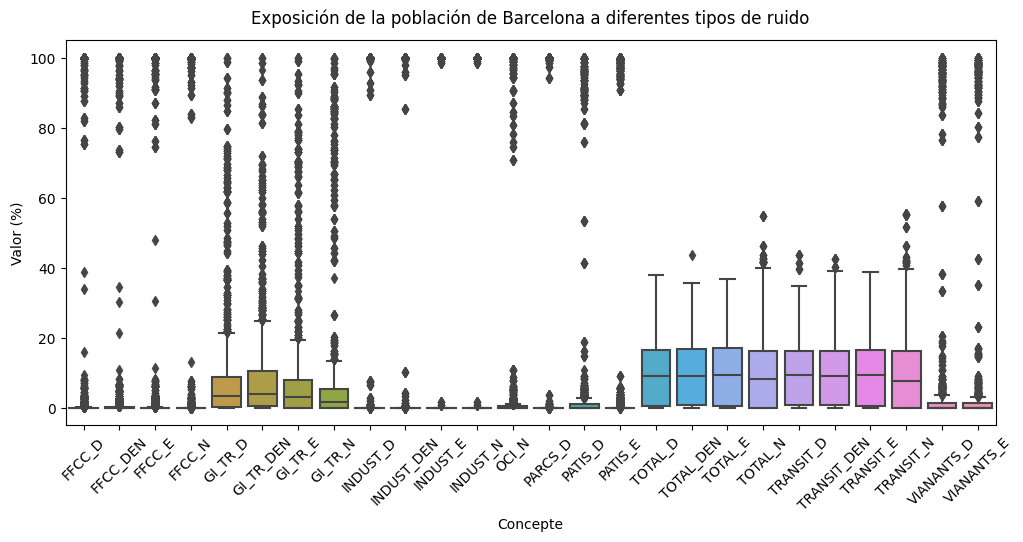

In [397]:
fig, axes = plt.subplots(figsize = (12,5))
sns.boxplot(data = df_unido, x = "Concepte", y = "Valor (%)")
axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
axes.set_title("Exposición de la población de Barcelona a diferentes tipos de ruido", y = 1.02);

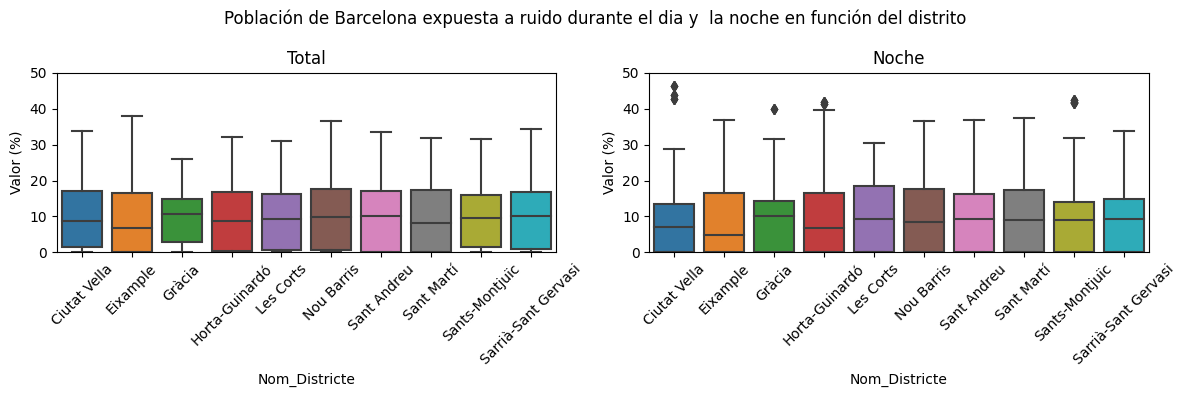

In [398]:
df_unido_ruido_total_dia = df_unido[(df_unido["Concepte"] == "TOTAL_D") | (df_unido["Concepte"] == "TOTAL_E")]
df_unido_ruido_total_noche = df_unido[df_unido["Concepte"] == "TOTAL_N"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.boxplot(data = df_unido_ruido_total_dia, x = "Nom_Districte", y = "Valor (%)", ax = axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title("Total")
axes[0].set_ylim(0, 50)
axes[0].set_yticks(range(0, 51, 10))

sns.boxplot(data = df_unido_ruido_total_noche, x = "Nom_Districte", y = "Valor (%)", ax = axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title("Noche")
axes[1].set_ylim(0, 50)
axes[1].set_yticks(range(0, 51, 10))

fig.suptitle("Población de Barcelona expuesta a ruido durante el dia y  la noche en función del distrito")
plt.tight_layout()

No hay cambios significativos entre la población de barcelona expuesta al ruido por el día y la noche ni entre distritos. Lo primero se explicar porque no estamos separando el tipo de ruido ni la intensidad de este, aunque nuestra hipótesis es que por la noche la intensidad del ruido es menor.

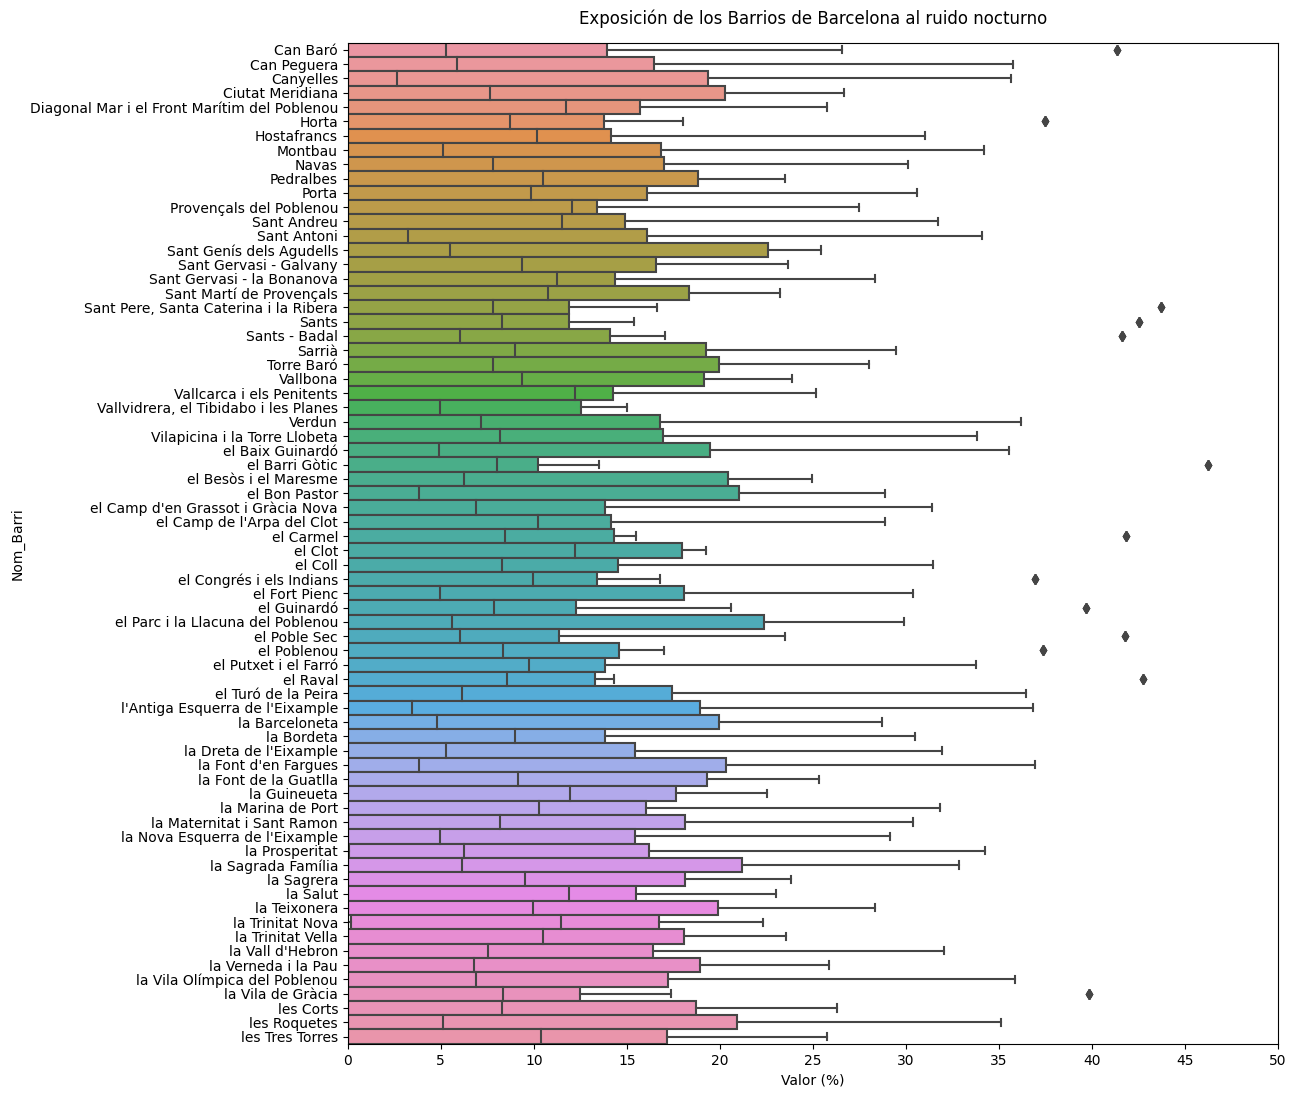

In [399]:
fig, axes = plt.subplots(figsize=(12, 13))
sns.boxplot(data = df_unido_ruido_total_noche, y = "Nom_Barri", x = "Valor (%)", width= 1)
axes.set_xlim(0, 50);
axes.set_xticks(range(0, 51, 5))
axes.set_title("Exposición de los Barrios de Barcelona al ruido nocturno", y = 1.01);

Podemos ver diferencias entre los distintos barrios y podemos ver también que el barrio con el menor promedio de exposición al ruido nocturno es Canyellels, que se encuentra alejado del nucleo urbano en una zona más montañosa.

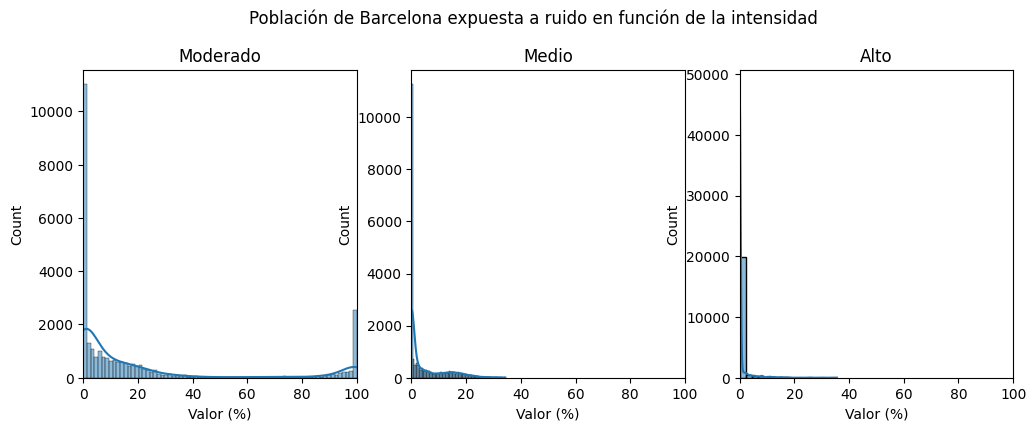

In [400]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

titles = ["Moderado", "Medio", "Alto"]
df_name = [df_unido_ruido_moderado, df_unido_ruido_medio, df_unido_ruido_alto] 

for ax, title, df_name in zip(axes, titles, df_name):
    sns.histplot(data = df_name["Valor (%)"], kde = True, ax = ax);
    ax.set_title(title)
    ax.set_xlim(0, 100)
    ax.set_xticks(range(0, 101, 20))

fig.suptitle("Población de Barcelona expuesta a ruido en función de la intensidad", y= 1.03)
plt.tight_layout;

Observamos que la población de Barcelona está mucho más expuesta a ruidos de intensidad moderada que ruidos de media intensidad. Además, hay muy poca parte de la población que esté expuesta a ruidos de alta intensidad.

In [401]:
df_unido_ruido_total_dia = df_unido[(df_unido["Concepte"] == "TOTAL_D") | (df_unido["Concepte"] == "TOTAL_E")]
df_unido_ruido_total_noche = df_unido[df_unido["Concepte"] == "TOTAL_N"]

In [402]:
# Separar por rango de sonidos
df_unido_ruido_moderado = df_unido[df_unido["Rang_soroll"].isin(["<40 dB", "40-45 dB", "45-50 dB","50-55 dB"])]
df_unido_ruido_medio = df_unido[df_unido["Rang_soroll"].isin(["55-60 dB", "60-65 dB", "65-70 dB"])]
df_unido_ruido_alto = df_unido[df_unido["Rang_soroll"].isin(["70-75 dB", "75-80 dB", ">=80 dB"])]

In [403]:
df_unido_ruido_medio[df_unido_ruido_medio["Nom_Districte"] == "Gràcia"].describe()

,Àrea (m2),Preu (euros/mes),Valor (%)
count,1560.000000,1560.000000,1560.000000
mean,61.889500,834.324000,4.670538
std,3.920362,71.057591,6.718729
min,56.220000,687.420000,0.000000
25%,58.155000,803.055000,0.000000
50%,62.830000,854.135000,0.000000
75%,64.372500,876.610000,11.000000
max,69.910000,946.590000,23.400000


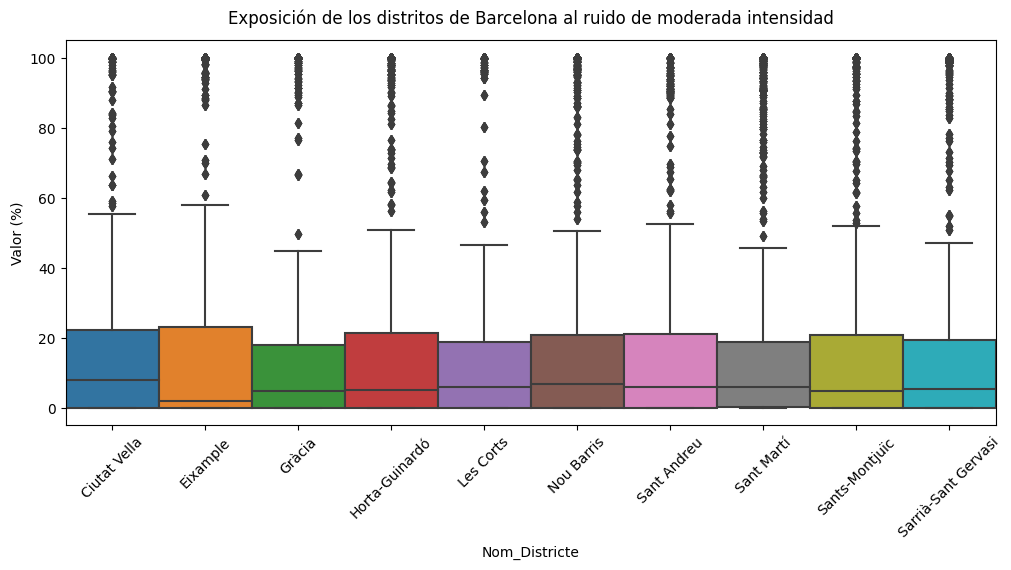

In [404]:
fig, axes = plt.subplots(figsize = (12,5))
sns.boxplot(data = df_unido_ruido_moderado, x = "Nom_Districte", y = "Valor (%)", width = 1);
axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
#axes.set_xlim(0, 50);
#axes.set_xticks(range(0, 51, 5))
axes.set_title("Exposición de los distritos de Barcelona al ruido de moderada intensidad", y = 1.02);

Los distritos están homogéneamente expuestos a ruido de intensidad moderada, destacando únicamente el distrito Eixample cuya población promedio no está menos expuesta a esta intensidad de ruido en comparación con el resto de habitantes de Barcelona.

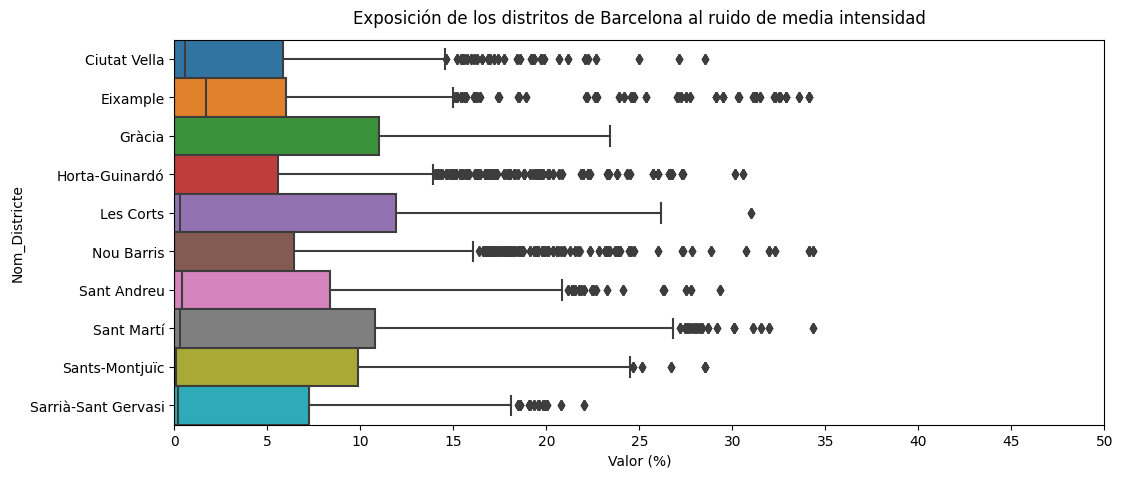

In [405]:
fig, axes = plt.subplots(figsize = (12,5))
sns.boxplot(data = df_unido_ruido_medio, y = "Nom_Districte", x = "Valor (%)", width = 1);
axes.set_xlim(0, 50);
axes.set_xticks(range(0, 51, 5))
axes.set_title("Exposición de los distritos de Barcelona al ruido de media intensidad", y = 1.02);

En cuanto al ruido de intensidad media se pueden observar mayores diferencias entre los distritos. Destacamos Gràcia y Les Corts, en los que que en la mayoría de zonas la población no se ve afectada por esta intensidad de ruido pero parece que hay zonas en concreto donde casi toda la población se ve afectada por el ruido. Eixample, distrito con menos población afectada para ruido de intensidad moderada, es el más afectado en promedio para el ruido de media intensidad.

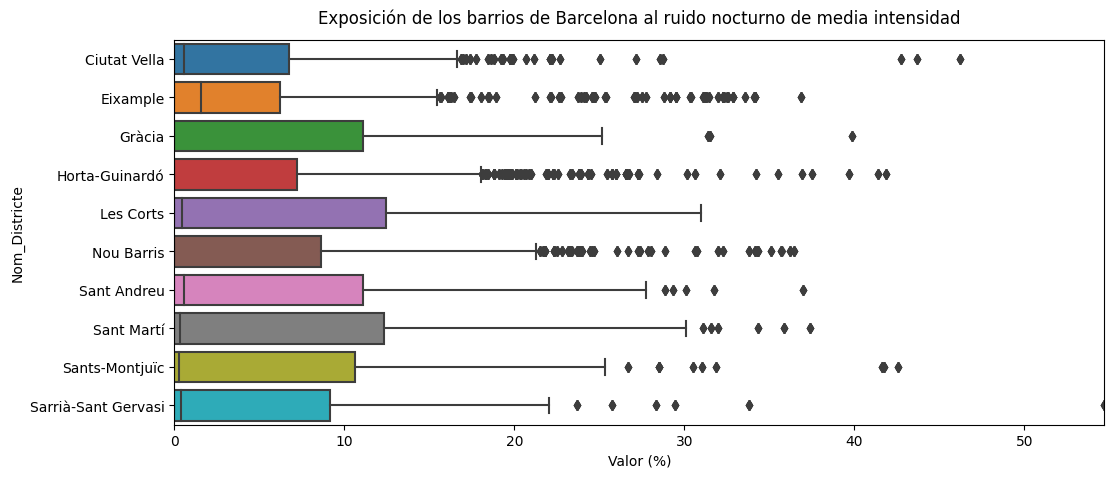

In [406]:
fig, axes = plt.subplots(figsize = (12,5))
df_unido_ruido_medio_noche = df_unido[(df_unido["Concepte"] == "TOTAL_N") | (df_unido["Rang_soroll"].isin(["55-60 dB", "60-65 dB", "65-70 dB"]))]
sns.boxplot(data = df_unido_ruido_medio_noche, y = "Nom_Districte", x = "Valor (%)")
plt.margins(x=0)
axes.set_title("Exposición de los barrios de Barcelona al ruido nocturno de media intensidad", y = 1.02);

No hay diferencia significativa en el ruido nocturno de media intensidad entre diferentes distritos. Sin embargo, sería conveniente realizar un análisis en mayor profundidad estudiando cada fuentes del ruido ya que puede ser que en unos barrios el ruido de intensidad media sea debido a ocio nocturno y en otros debido al tráfico de grandes avenidas. 

### Extra: predicción de precios de viviendas en función de solo 1 atributo: su superficie

En esta sección vamos a predecir de forma muy sencilla los precios de las viviendas de Barcelona suponiendo que sólo tuviéramos como información la superficie de la vivienda de la que queremos conocer su precio.

In [407]:
columnas_numerico = ["Àrea (m2)", "Preu (euros/mes)", "Valor (%)"]

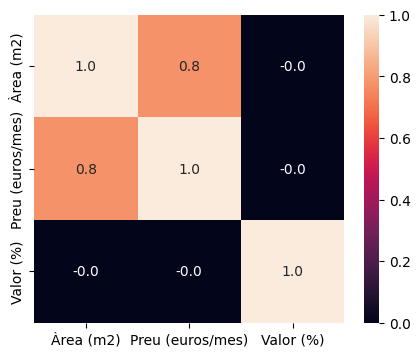

In [408]:
matriz_correlacion = df_unido[columnas_numerico].corr()

fig, axes = plt.subplots(figsize = (5, 4))
sns.heatmap(matriz_correlacion, annot=True, fmt=".1f");

Si nos fijamos en el mapa de calor, vemos que hay una correlación positiva fuerte entre el área y el precio. Por otra parte, podríamos creer que precio y área no están nada correlacionados con el porcetanje de población afectada por ruido. Sin embargo, habría que hacer un análisis más en profundidad para poder afirmar esto, ya que al calcular el coeficiente de correlación del resto de variables con la categoría "Valor (%)" los tipos de ruido y sus rangos de intensidad están mezclados.


Como precio y área están fuertemente correlacionados cobra fuerza nuestra hipótesis de que podremos usar un modelo que, conociendo la superficie de una vivienda prediga su alquiler mensual.

In [409]:
df_alquiler_area["Preu (euros/mes)"].describe()

count     274.000000
mean      828.226071
std       253.467187
min       302.520000
25%       680.327500
50%       768.915000
75%       912.162500
max      1882.420000
Name: Preu (euros/mes), dtype: float64

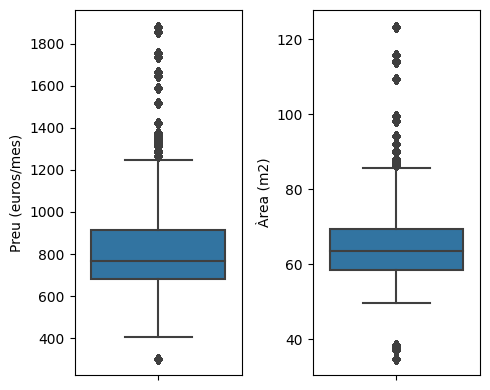

In [410]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 4))
sns.boxplot(y = df_unido["Preu (euros/mes)"], ax = axes[0])
sns.boxplot(y = df_unido["Àrea (m2)"], ax = axes[1])

plt.tight_layout()
plt.show()

In [411]:
# Eliminando outliers mediante el método Tukey's fences 
Q1_precio = df_unido["Preu (euros/mes)"].quantile(0.25)
Q3_precio = df_unido["Preu (euros/mes)"].quantile(0.75)
IQR_precio = Q3_precio - Q1_precio
precio_max = Q3_precio + 1.5*IQR_precio
precio_min = Q1_precio - 1.5*IQR_precio

Q1_area = df_unido["Àrea (m2)"].quantile(0.25)
Q3_area = df_unido["Àrea (m2)"].quantile(0.75)
IQR_area = Q3_area - Q1_area
area_max = Q3_area + 1.5*IQR_area
area_min = Q1_area - 1.5*IQR_area

In [412]:
df_unido_sin_outliers = df_unido[(df_unido["Preu (euros/mes)"].between(precio_min, precio_max)) 
& (df_unido["Àrea (m2)"].between(area_min, area_max))]

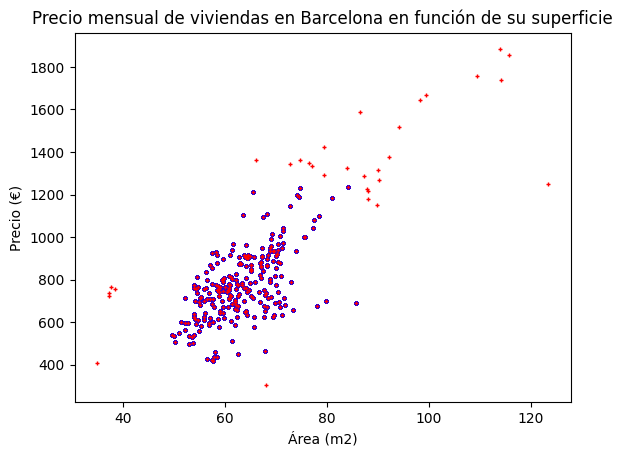

In [413]:
plt.plot(df_unido_sin_outliers["Àrea (m2)"], df_unido_sin_outliers["Preu (euros/mes)"], "o", markersize = "2", c ="b", label = "Data sin outliers")
plt.plot(df_alquiler_area["Àrea (m2)"], df_alquiler_area["Preu (euros/mes)"], "+", markersize = "3", c = "r", label = "Data")
plt.xlabel("Área (m2)")
plt.ylabel("Precio (€)")
plt.title("Precio mensual de viviendas en Barcelona en función de su superficie");
# With what argument do we remove outliers?? just by saying they fall out of the IQR of the boxplot??

In [414]:
X = np.array(df_unido_sin_outliers["Àrea (m2)"]).reshape(-1,1)
y = df_unido_sin_outliers["Preu (euros/mes)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

y_baseline = [y_test.mean()] * len(y_test)
print(mean_absolute_error(y_baseline, y_test))

123.96572863556003


In [415]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

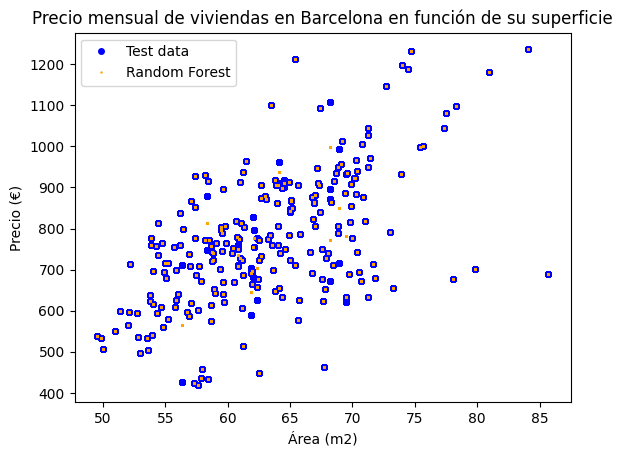

In [416]:
plt.plot(X_test, y_test, "o", markersize = "4", c ="b", label = "Test data")
plt.plot(X_test, y_pred_rf, "+", markersize = "1", c = "orange", label = "Random Forest")
plt.legend()

plt.xlabel("Área (m2)")
plt.ylabel("Precio (€)")
plt.title("Precio mensual de viviendas en Barcelona en función de su superficie");

In [417]:
print((mean_absolute_error(y_pred_rf, y_test)))

7.965460180792945


Nuestro modelo se aleja en promedio solo 8€ del precio real del alquiler mensual de las viviendas.

### Reducción de dimensionalidad mediante PCA

Uutilizamos PCA para reducir las dimensiones y conservar aquellas que guardan la mayor varianza. 

Es importante excluir las variables categóricas de la PCA ya que estas tendrían mayor influencia en la varianza al calcular las contribuciones para las componentes principales. Para evitar esto, también debemos estandarizar las variables numéricas para que todas tengan la misma media y distribución estandar para que la contribución de unas no eclipse a las otras en la PCA. 

In [418]:
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71240 entries, 0 to 71239
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Trimestre         71240 non-null  category
 1   Codi_Districte    71240 non-null  category
 2   Nom_Districte     71240 non-null  category
 3   Codi_Barri        71240 non-null  category
 4   Nom_Barri         71240 non-null  category
 5   Àrea (m2)         71240 non-null  float64 
 6   Preu (euros/mes)  71240 non-null  float64 
 7   Concepte          71240 non-null  category
 8   Rang_soroll       71240 non-null  category
 9   Valor (%)         71240 non-null  float64 
dtypes: category(7), float64(3)
memory usage: 2.1 MB


In [419]:
scaler = StandardScaler()
df_estandarizado = pd.DataFrame(scaler.fit_transform(df_unido[columnas_numerico]), columns = columnas_numerico)

In [420]:
df_estandarizado.describe()

,Àrea (m2),Preu (euros/mes),Valor (%)
count,7.124000e+04,7.124000e+04,7.124000e+04
mean,-1.516037e-16,-2.585243e-16,-5.428311e-17
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-2.589113e+00,-2.077855e+00,-4.295549e-01
25%,-5.792816e-01,-5.851921e-01,-4.295549e-01
50%,-1.369652e-01,-2.344272e-01,-4.295549e-01
75%,3.582414e-01,3.331325e-01,-6.314457e-02
max,4.957137e+00,4.166705e+00,3.865994e+00


In [421]:
pca =  PCA()
data_pca_num = pca.fit_transform(df_estandarizado)

In [422]:
pca_varianzas_num = pca.explained_variance_ratio_
pca_varianzas_explicadas_num = pca.explained_variance_
pca_varianzas_acumulativas_num = np.cumsum(pca_varianzas_explicadas_num) / np.sum(pca_varianzas_explicadas_num)

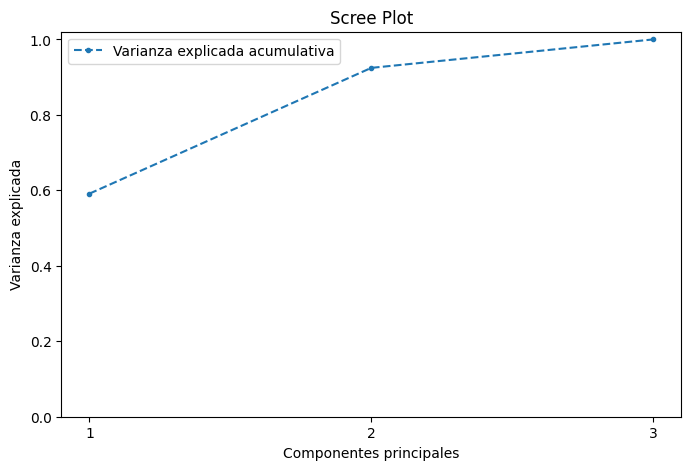

In [423]:
fig, axes = plt.subplots(figsize = (8,5))
plt.plot(range(1, len(pca_varianzas_acumulativas_num) + 1), pca_varianzas_acumulativas_num, marker = "o",linestyle='dashed', markersize = 3
         , label = "Varianza explicada acumulativa")
axes.set_xticks(range(1, 4, 1))
axes.set_yticks(np.arange(0, 1.1, 0.2))

plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada")
plt.legend()
plt.title('Scree Plot')
plt.show()

Ahora veremos la influencia de las variables en la primera componente.

In [424]:
componentes = pca.components_
componentes

array([[ 7.07106781e-01,  7.07106781e-01,  5.75808333e-17],
       [ 0.00000000e+00, -8.14315954e-17,  1.00000000e+00],
       [ 7.07106781e-01, -7.07106781e-01, -5.75808333e-17]])

In [425]:
pd.DataFrame(componentes, columns = columnas_numerico, index = ["Primer Componente", "Segundo Componente", "Tercer Componente"]).round(10)

,Àrea (m2),Preu (euros/mes),Valor (%)
Primer Componente,0.707107,0.707107,0.0
Segundo Componente,0.000000,-0.000000,1.0
Tercer Componente,0.707107,-0.707107,-0.0


A pesar de lo dicho anteriormente, aunque se desaconseja es posible incluir las variables categóricas codificadas en la PCA. A continuación vamos a ver cómo proceder si realizamos PCA sobre todo el dataset. 

Para ello es necesario codificar las variables categóricas mediante onehotencoding. Al realizar esto lo que hacemos es crear una tabla de 0s y 1s donde tenemos tantas columnas como posibles valores de variables tuviésemos antes. Por ejemplo, al aplicar onehotencoding a la variable Trimestre pasaremos a tener una tabla de 4 columnas (Trimestre_1, Trimestre_2, Trimestre_3, Trimestre_4) y tantos elementos como haya en nuestro dataset. Así, cada elemento tendrá 0 en todas las columnas excepto 1 en aquella que tenga su valor correspondiente.

In [426]:
columnas_numerico = ["Àrea (m2)", "Preu (euros/mes)", "Valor (%)"]
columnas_categorico = ["Trimestre", "Codi_Districte", "Nom_Districte", "Codi_Barri", "Nom_Barri", "Concepte", "Rang_soroll"]

df_unido_numerico = df_unido[columnas_numerico]
df_unido_categorico = df_unido[columnas_categorico]

In [427]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_unido_numerico), columns = columnas_numerico)

ohe = OneHotEncoder(sparse_output=False, drop=None)
df_transformado = ohe.fit_transform(df_unido_categorico)
ohe_columns = ohe.get_feature_names_out(columnas_categorico)
df_ohe = pd.DataFrame(df_transformado, columns = ohe_columns)

In [428]:
df_ohe.head()

,Trimestre_1,Trimestre_2,Trimestre_3,Trimestre_4,Codi_Districte_1,Codi_Districte_2,Codi_Districte_3,Codi_Districte_4,Codi_Districte_5,Codi_Districte_6,...,Rang_soroll_40-45 dB,Rang_soroll_45-50 dB,Rang_soroll_50-55 dB,Rang_soroll_55-60 dB,Rang_soroll_60-65 dB,Rang_soroll_65-70 dB,Rang_soroll_70-75 dB,Rang_soroll_75-80 dB,Rang_soroll_<40 dB,Rang_soroll_>=80 dB
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora tenemos 200 columnas 

In [429]:
# Confirmar que lo hemos hecho bien
num_valores_distintos = 0
for columna in df_unido_categorico.columns:
    num_valores_distintos += df_unido[columna].nunique()
print("En el dataset hay", num_valores_distintos, "valores categóricos distintos")

En el dataset hay 200 valores categóricos distintos


In [430]:
columnas_numerico = ["Àrea (m2)", "Preu (euros/mes)", "Valor (%)"]
columnas_categorico = ["Trimestre", "Codi_Districte", "Nom_Districte", "Codi_Barri", "Nom_Barri", "Concepte", "Rang_soroll"]

df_unido_numerico = df_unido[columnas_numerico]
df_unido_categorico = df_unido[columnas_categorico]

In [431]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_unido_numerico), columns = columnas_numerico)

ohe = OneHotEncoder(sparse_output=False, drop=None)
df_t = ohe.fit_transform(df_unido_categorico)
ohe_columns = ohe.get_feature_names_out(columnas_categorico)
df_ohe = pd.DataFrame(df_t, columns = ohe_columns)

In [432]:
df_ohe.head()

,Trimestre_1,Trimestre_2,Trimestre_3,Trimestre_4,Codi_Districte_1,Codi_Districte_2,Codi_Districte_3,Codi_Districte_4,Codi_Districte_5,Codi_Districte_6,...,Rang_soroll_40-45 dB,Rang_soroll_45-50 dB,Rang_soroll_50-55 dB,Rang_soroll_55-60 dB,Rang_soroll_60-65 dB,Rang_soroll_65-70 dB,Rang_soroll_70-75 dB,Rang_soroll_75-80 dB,Rang_soroll_<40 dB,Rang_soroll_>=80 dB
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [433]:
df_para_pca = pd.concat([df_scaled, df_ohe], axis=1)

In [434]:
pca_t =  PCA()
data_pca_total = pca_t.fit_transform(df_para_pca) 

In [435]:
pca_varianzas_t = pca_t.explained_variance_ratio_
pca_varianzas_explicadas_t = pca_t.explained_variance_
pca_varianzas_acumulativas_t = np.cumsum(pca_varianzas_explicadas_t) / np.sum(pca_varianzas_explicadas_t)

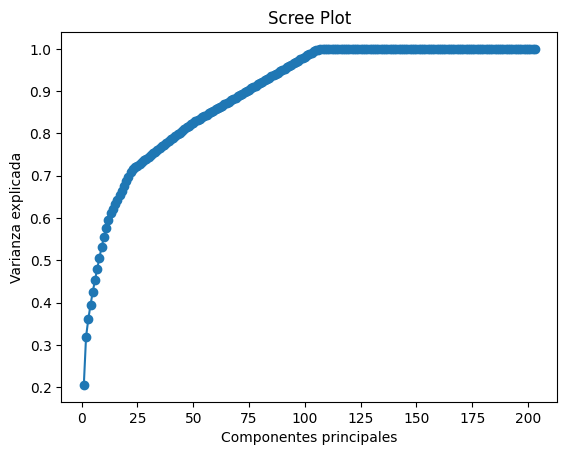

In [436]:
plt.plot(range(1, len(pca_varianzas_acumulativas_t) + 1), pca_varianzas_acumulativas_t, marker='o')
plt.xlabel('Componentes principales')
plt.ylabel('Varianza explicada')
plt.title('Scree Plot')
plt.show()

In [437]:
print(pca_varianzas_acumulativas_t[75], pca_varianzas_acumulativas_t[100])

0.9067077553177938 0.9847529942120364


In [438]:
componentes_t = pca_t.components_

In [439]:
pd.DataFrame(componentes_t, columns = df_para_pca.columns).round(10).head()

,Àrea (m2),Preu (euros/mes),Valor (%),Trimestre_1,Trimestre_2,Trimestre_3,Trimestre_4,Codi_Districte_1,Codi_Districte_2,Codi_Districte_3,...,Rang_soroll_40-45 dB,Rang_soroll_45-50 dB,Rang_soroll_50-55 dB,Rang_soroll_55-60 dB,Rang_soroll_60-65 dB,Rang_soroll_65-70 dB,Rang_soroll_70-75 dB,Rang_soroll_75-80 dB,Rang_soroll_<40 dB,Rang_soroll_>=80 dB
0,0.670297,0.686878,-0.000000,-0.003487,-0.014316,0.014943,0.002860,-0.017590,0.045251,-0.025050,...,-0.000000,-0.00000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,0.00000,-0.000000
1,-0.000000,0.000000,0.967989,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,...,-0.011165,-0.01444,-0.020627,-0.018882,-0.021431,-0.028032,-0.035837,-0.04248,0.23599,-0.043094
2,0.456820,-0.330179,-0.000000,0.067906,0.042831,-0.043070,-0.067667,-0.117304,0.031991,-0.087978,...,0.000000,0.00000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.00000,-0.000000
3,0.118034,-0.063816,0.000000,0.038657,-0.013302,-0.004383,-0.020972,-0.035516,0.037739,-0.025219,...,0.000000,-0.00000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.00000,0.00000,-0.000000
4,0.280016,-0.254047,0.000000,0.195746,-0.007425,-0.077581,-0.110740,-0.136859,-0.029180,-0.188970,...,0.000000,0.00000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.00000,-0.000000


Comprobamos a aplicar FAMD (Factor analysis of mixed data), otro método de reducción de dimensionalidad orientado a tratar tanto data numérica como categórica. 

In [440]:
famd = prince.FAMD(n_components = 200, random_state=42)
famd_result = famd.fit_transform(df_unido)

In [441]:
fmd_cumulativa = famd.cumulative_percentage_of_variance_ / 100

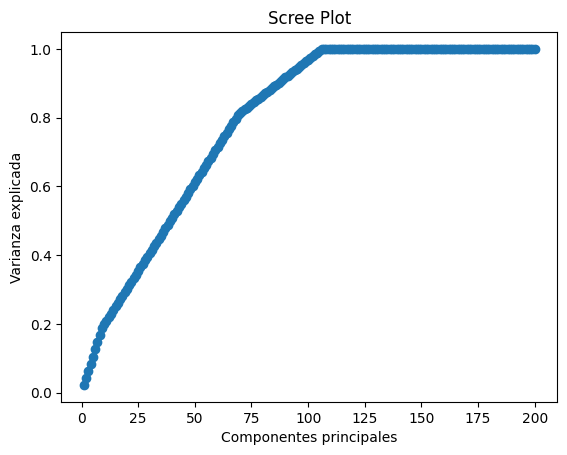

In [442]:
plt.plot(range(1, len(fmd_cumulativa) + 1), fmd_cumulativa, marker='o')
plt.xlabel('Componentes principales')
plt.ylabel('Varianza explicada')
plt.title('Scree Plot')
plt.show()

No hay mejoría respecto a PCA, de hecho para los primeros componentes principales de la PCA conseguíamos mayor vairanza explicada.

### Conclusiones

* Trabajamos con un dataset balanceado puesto que contamos practicamente con el mismo número de elementos para cada tipo de variable categórica. Esto es un buen indicador que nos facilitará el trabajo si más adelante quisiéramos aplicar modelos de machine learning para predecir alguna variable. Por ejemplo, podríamos intentar predecir el precio de una vivienda en función de su área, el distrito al que pertenece y la población total afectada al ruido en ese barrio.

* La población de Barcelona está mucho más expuesta a ruidos de intensidad moderada que a ruidos de media intensidad y muy poca parte lo está a ruidos de alta intensidad. No hay grandes diferencias en la exposición al ruido entre los distritos, sin diferenciar las fuentes del ruido. Para un análisis en mayor profundidad se propone separar las fuentes y analizar las diferencias entre distritos por cada fuente. 

* En cuanto al análisis de las componentes principales:
  - Al aplicarlo solo con variables numéricas vemos que las variables con mayor influencia en la primera componente son área y precio. En la segunda componente es la variable valor. Puesto que uno los objetivos es reducir la dimensionalidad y como con las dos primeras componentes mantenemos alrededor del 90% de la varianza explicada, podríamos deshacernos de la tercera componente y trabajar a partir de ahora solo con las dos primeras.
  - Al aplicarlo sobre la totalidad del dataset observamos que mantiendo los primeros 75 componentes principales preservamos un 90% de la varianza y manteniendo los 100 primeros casi el 100%. Como nuestro objetivo es reducir la dimensionalidad sacrificamos algo de varianza por reducir la dimensión del dataset de 203 a 75.  